II. Programming

Francisco Silva (110409) and Joana Cardoso (109864)

1.a

In [101]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('Breast_cancer_dataset.csv')

le = LabelEncoder()
y = le.fit_transform(data['diagnosis'])
X = data.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1, errors='ignore')

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)


knn_5 = KNeighborsClassifier(n_neighbors=5)
gnb = GaussianNB()

knn_scores = cross_val_score(knn_5, X, y, cv=cv_strategy, scoring='accuracy')

gnb_scores = cross_val_score(gnb, X, y, cv=cv_strategy, scoring='accuracy')

knn_mean_acc = knn_scores.mean()
gnb_mean_acc = gnb_scores.mean()

knn_std = knn_scores.std()
gnb_std = gnb_scores.std()

print("kNN (k=5):")
print(f"Precisão Média: {knn_mean_acc:.4f}")
print(f"Desvio-Padrão: {knn_std:.4f}\n")
print("Naïve Bayes Gaussiano:")
print(f"Precisão Média: {gnb_mean_acc:.4f}")
print(f"Desvio-Padrão: {gnb_std:.4f}")

kNN (k=5):
Precisão Média: 0.9315
Desvio-Padrão: 0.0169

Naïve Bayes Gaussiano:
Precisão Média: 0.9385
Desvio-Padrão: 0.0166


O Naïve Bayes Gaussiano é mais estável (Desvio-Padrão = 0.0166) do que o kNN (Desvio-Padrão = 0.0169).

Isto acontece porque o Naïve Bayes é um modelo paramétrico que estima a distribuição de probabilidade dos dados. As suas fronteiras de decisão são definidas por esses parâmetros (média e variância) e são, portanto, mais robustas e menos sensíveis às pequenas variações no conjunto de treino de cada fold (baixa variância do modelo).

1.b

In [102]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

knn_scores_unscaled = cross_val_score(knn_5, X, y, cv=cv_strategy, scoring='accuracy')
knn_mean_acc = knn_scores_unscaled.mean() 

scaler = MinMaxScaler()
pipeline_knn_scaled = Pipeline([
    ('scaler', scaler),
    ('knn', knn_5) 
])

knn_scores_scaled = cross_val_score(pipeline_knn_scaled, X, y, cv=cv_strategy, scoring='accuracy')
knn_mean_acc_scaled = knn_scores_scaled.mean()

print("kNN (k=5) COM MIN-MAX SCALER")
print(f"Precisão Média do kNN ESCALADO: {knn_mean_acc_scaled:.4f}")


kNN (k=5) COM MIN-MAX SCALER
Precisão Média do kNN ESCALADO: 0.9736


O impacto do Min-Max Scaler na performance do modelo kNN mostra um aumento significativo na precisão, subindo de 0.9315 para 0.9736. Esta melhoria ocorre porque o kNN é baseado em distância. Nos dados não escalados, as características com maior magnitude dominam o cálculo da distância, fazendo com que o modelo ignore as características de menor escala. O Min-Max Scaler transforma todas as características para um intervalo uniforme, garantindo que todas as características contribuam de forma igual para a distância. Isso permite que o kNN encontre os vizinhos corretos e defina limites de decisão mais precisos.

1.c

In [103]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel

knn_5 = KNeighborsClassifier(n_neighbors=5)
gnb = GaussianNB()

scaler_minmax = MinMaxScaler()
pipeline_knn_scaled = Pipeline([
    ('scaler', scaler_minmax),
    ('knn', knn_5) 
])
knn_scores_scaled = cross_val_score(pipeline_knn_scaled, X, y, cv=cv_strategy, scoring='accuracy')

scaler_standard = StandardScaler()
pipeline_gnb_scaled = Pipeline([
    ('scaler', scaler_standard),
    ('gnb', gnb) 
])
gnb_scores_scaled = cross_val_score(pipeline_gnb_scaled, X, y, cv=cv_strategy, scoring='accuracy')

t_stat, p_value_bicaudal = ttest_rel(knn_scores_scaled, gnb_scores_scaled, alternative='greater')

p_value_unilateral = p_value_bicaudal

print(f"P-valor (Unilateral): {p_value_unilateral:.4f}")


P-valor (Unilateral): 0.0017


Usando o T-test, vemos que o P-valor unilateral obtido foi de 0.0017. Uma vez que este valor é menor que o nível de significância α=0.05, rejeitamos a hipótese nula, concluindo então que o kNN Escalado é estatisticamente superior ao Naïve Bayes em termos de precisão neste conjunto de dados.

Isto significa que a superioridade observada do kNN Escalado (Precisão=0.9736) sobre o Naïve Bayes (Precisão=0.9386) não é devida ao acaso e é estatisticamente significativa.

2.a

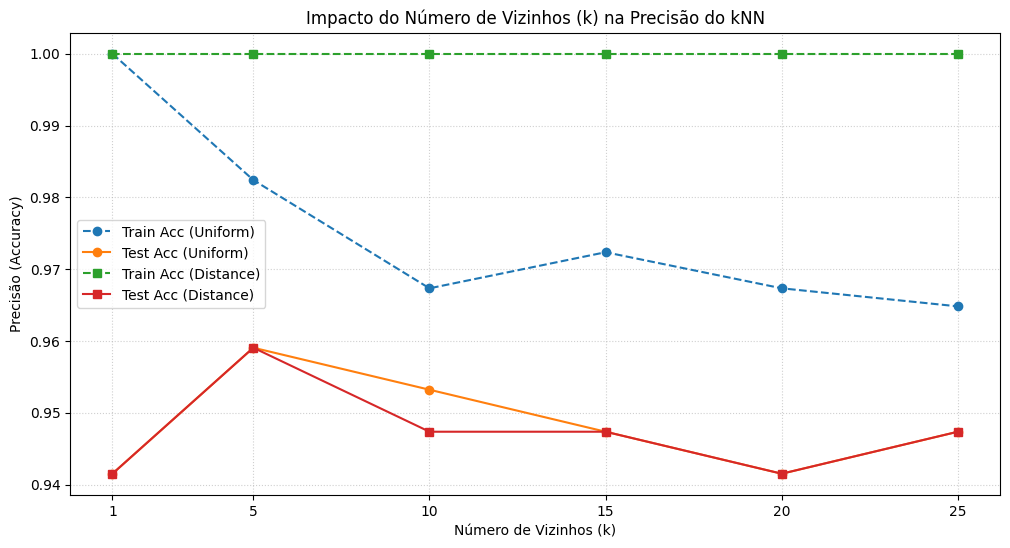

In [104]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X) 
y_target = y 

RANDOM_STATE = 1 
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_target, test_size=0.3, random_state=RANDOM_STATE, stratify=y_target
)

k_values = [1, 5, 10, 15, 20, 25]
weights_options = ['uniform', 'distance']
results = []

for k in k_values:
    for w in weights_options:
        knn = KNeighborsClassifier(n_neighbors=k, weights=w)
        
        knn.fit(X_train, y_train)
        
        train_acc = knn.score(X_train, y_train)
        test_acc = knn.score(X_test, y_test)
        
        results.append({
            'k': k, 
            'weights': w, 
            'train_acc': train_acc, 
            'test_acc': test_acc
        })

results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))

uniform_data = results_df[results_df['weights'] == 'uniform']
plt.plot(uniform_data['k'], uniform_data['train_acc'], label='Train Acc (Uniform)', marker='o', linestyle='--')
plt.plot(uniform_data['k'], uniform_data['test_acc'], label='Test Acc (Uniform)', marker='o', linestyle='-')

distance_data = results_df[results_df['weights'] == 'distance']
plt.plot(distance_data['k'], distance_data['train_acc'], label='Train Acc (Distance)', marker='s', linestyle='--')
plt.plot(distance_data['k'], distance_data['test_acc'], label='Test Acc (Distance)', marker='s', linestyle='-')

plt.title('Impacto do Número de Vizinhos (k) na Precisão do kNN')
plt.xlabel('Número de Vizinhos (k)')
plt.ylabel('Precisão (Accuracy)')
plt.xticks(k_values)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

2.b

O aumento do número de vizinhos (k) tem como impacto a suavização da fronteira de decisão, o que melhora a capacidade de generalização do modelo até um ponto ótimo. O modelo começa com alta variância e bias baixo (quando k é pequeno) e move-se em direção a uma baixa variância e bias alto (quando k é grande), isto é chamado de Bias-Variance Trade-off.

Quando k é pequeno (k=1) temos overfitting, pois o modelo é muito sensível a padrões específicos dos dados de treino. Quando k é grande (k=10, 15, 20, 25) temos underfitting, pois o modelo simplifica a realidade dos dados. O valor ótimo de k está então em k=5, onde a precisão de teste é maximizada.

3.

A nossa escolha ideal é o kNN Escalado.

Fator 1: Precisão

A precisão é o fator mais importante. Os teste mostram que o kNN Escalado (Precisão: 0.9736) é estatisticamente superior ao Naïve Bayes (Precisão: 0.9386). Esta superioridade deriva da capacidade do kNN em modelar fronteiras de decisão não-lineares, algo que o Naïve Bayes, um modelo mais simples, não consegue replicar, tornando o kNN mais fiável para minimizar erros de diagnóstico.

Fator 2: Custo Operacional 

Embora o Naïve Bayes seja muito mais rápido e escalável na fase de previsão (complexidade O(D)), o kNN tem uma desvantagem para grandes conjuntos de dados, pois a previsão torna-se lenta com muitos dados (O(N⋅D)). Contudo, dado que a precisão clínica é inegociável, o custo extra de computação do kNN é aceitável em comparação com o risco de um diagnóstico incorreto, desde que o volume de dados de referência não seja excessivo. Além disso, o kNN permite uma explicação mais intuitiva do diagnóstico o que é uma vantagem essencial para a confiança médica.